In [1]:
# standarad imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata

# import regular expression operations
import re

# import natural language toolkit
import nltk
# import stopwords list
from nltk.corpus import stopwords
# import wordcloud
from wordcloud import WordCloud

import requests
from bs4 import BeautifulSoup
import os
from pprint import pprint 
import time
import json

import acquire as a
import wrangle as w

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



# acquire

In [2]:
data = pd.read_json('github_data.json')
data

,repo,language,readme_contents
0,/nyukat/breast_cancer_classifier,Jupyter Notebook,# Deep Neural Networks Improve Radiologists' P...
1,/lishen/end2end-all-conv,Jupyter Notebook,Shield: [![CC BY-NC-SA 4.0][cc-by-nc-sa-shield...
2,/ImagingLab/ICIAR2018,Python,# ICIAR2018\n### Two-Stage Convolutional Neura...
3,/Jean-njoroge/Breast-cancer-risk-prediction,Jupyter Notebook,# Breast-cancer-risk-prediction\n\n> Necessity...
4,/abhinavsagar/breast-cancer-classification,Jupyter Notebook,# Breast-cancer-classification\n\nBreast Cance...
...,...,...,...
90,/BishalDali/Breast_Cancer_Prediction,Jupyter Notebook,# Breast_Cancer_Prediction
91,/IndianAIProduction-Channel/Breast-Cancer-Dete...,HTML,# Breast-Cancer-Detection-App\n Breast Cancer ...
92,/gmineo/Breast-Cancer-Prediction-Project,R,# Breast-Cancer-Prediction\n\nChoose-your-own ...
93,/iharnoor/BreastCancer-Kmeans,Python,# BreastCancer-Kmeans\nClustering the data int...


In [3]:
df = pd.DataFrame(data)


# Prepare!

In [4]:
#df = df.dropna()

In [5]:
# text cleaning on a df column named 'readme'. removing special character and words.
df.readme_contents = df.readme_contents.str.replace('[/,_,-,:,"]', '', regex=True)

df.readme_contents = df.readme_contents.str.replace('heavy', '').str.replace('check', '').str.replace('mark', '')

In [6]:
df.language.value_counts()


language
Python              45
Jupyter Notebook    29
R                    4
HTML                 4
MATLAB               3
TeX                  2
C#                   2
Matlab               2
Objective-C          1
Dart                 1
Name: count, dtype: int64

In [7]:
df['clean_norm_token'] = df.readme_contents.apply(w.tokenize).apply(w.basic_clean).apply(w.remove_stopwords).apply(w.lemmatize)


# tokenizes, cleans, remove stopwprds, lemmatize the text in the readme_contents and 
#stores the processed text in a new column clean_norm_token

df.clean_norm_token = df.clean_norm_token.str.replace('124', '')

# it removes any occurences of the string '124' from the clean_norm_token column

In [8]:
#Combine 'Jupyter Notebook' with 'Other' and create a new value 'Other'
df['language'] = df['language'].replace({'Jupyter Notebook': 'Other'})

In [9]:
#in language column replace language with other if it is not in the top 3 languages
top_5 = df.language.value_counts().head(5).index.tolist()
print(top_5)
df.language = df.language.apply(lambda x: x if x in top_5 else 'other')

['Python', 'Other', 'R', 'HTML', 'MATLAB']


In [10]:
# List of languages to combine into "Other"
languages_to_combine = ['Jupyter Notebook', 'MATLAB', 'TeX', 'C#', 'Matlab', 'Objective-C', 'Dart']
# Replace the specified languages with "Other"
df['language'] = df['language'].replace(languages_to_combine, 'other')
df

,repo,language,readme_contents,clean_norm_token
0,/nyukat/breast_cancer_classifier,Other,# Deep Neural Networks Improve Radiologists' P...,deep neural network improve radiologist ' perf...
1,/lishen/end2end-all-conv,Other,Shield [![CC BY-NC-SA 4.0][cc-by-nc-sa-shield]...,shield cc byncsa 40 ccbyncsashield ccbyncsa wo...
2,/ImagingLab/ICIAR2018,Python,# ICIAR2018\n### Two-Stage Convolutional Neura...,iciar2018 twostage convolutional neural networ...
3,/Jean-njoroge/Breast-cancer-risk-prediction,Other,# Breast-cancer-risk-prediction\n\n> Necessity...,breastcancerriskprediction necessity mother in...
4,/abhinavsagar/breast-cancer-classification,Other,# Breast-cancer-classification\n\nBreast Cance...,breastcancerclassification classification usin...
...,...,...,...,...
90,/BishalDali/Breast_Cancer_Prediction,Other,# BreastCancerPrediction,breastcancerprediction
91,/IndianAIProduction-Channel/Breast-Cancer-Dete...,HTML,# Breast-Cancer-Detection-App\n Breast Cancer ...,breastcancerdetectionapp detection app using m...
92,/gmineo/Breast-Cancer-Prediction-Project,R,# Breast-Cancer-Prediction\n\nChoose-your-own ...,breastcancerprediction chooseyourown project h...
93,/iharnoor/BreastCancer-Kmeans,Python,# BreastCancer-Kmeans\nClustering the data int...,breastcancerkmeans clustering data using kmean...


In [11]:
df.language.value_counts()


language
Python    45
Other     29
other     13
R          4
HTML       4
Name: count, dtype: int64

In [12]:
#baseline is 47%
df.language.value_counts(normalize=True)
#the relative frequency of each programming language in  dataset.

language
Python    0.473684
Other     0.305263
other     0.136842
R         0.042105
HTML      0.042105
Name: proportion, dtype: float64

# explore

In [13]:
#calls the split function from wrangle.py
train, validate, test = w.split_function_cat_target(df, "language")

In [14]:
train.head()

,repo,language,readme_contents,clean_norm_token
24,/sayakpaul/Breast-Cancer-Detection-using-Deep-...,Other,**Context** \n\nInvasive Ductal Carcinoma (IDC...,context invasive ductal carcinoma idc common s...
64,/gayathri1462/Breast-Cancer-Detection-Web-App,Other,# Breast Cancer Detection Web Application\n\n#...,detection web application web application pred...
39,/javismiles/Deep-Learning-predicting-breast-ca...,Other,# Predicting Cancer Malignancy with a 2 layer ...,predicting malignancy 2 layer neural network c...
6,/nyukat/BIRADS_classifier,Python,# High-resolution breast cancer screening with...,highresolution screening multiview deep convol...
93,/iharnoor/BreastCancer-Kmeans,Python,# BreastCancer-Kmeans\nClustering the data int...,breastcancerkmeans clustering data using kmean...


In [15]:
python_words = w.clean(' '.join(train[train.language=='Python']['clean_norm_token']))
jupyter_notebook_words = w.clean(' '.join(train[train.language=='Jupyter Notebook']['clean_norm_token']))
html_words = w.clean(' '.join(train[train.language=='HTML']['clean_norm_token']))
r_words = w.clean(' '.join(train[train.language=='R']['clean_norm_token']))
other_words = w.clean(' '.join(train[train.language=='other']['clean_norm_token']))

all_words = w.clean(' '.join(df['clean_norm_token']))
#various programming languages and aggregating the words associated with each language

In [16]:
#how often each word appears in various lists of words, 
#possibly corresponding to different programming languages or technologies.
python_freq = pd.Series(python_words).value_counts()
jupyter_notebook_freq = pd.Series(jupyter_notebook_words).value_counts()
html_freq = pd.Series(html_words).value_counts()
r_freq = pd.Series(r_words).value_counts()
other_freq = pd.Series(other_words).value_counts()

all_freq = pd.Series(all_words).value_counts()

In [17]:
def make_ngrams(words, n):
    return pd.Series(nltk.ngrams(words, n)).value_counts().head(20)
    

In [18]:
def plot_bigrams(words):
    word_data = {k[0] + ' ' + k[1]: v for k, v in words.to_dict().items()}
    
    word_img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(word_data)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(word_img)
    plt.axis('off')
    plt.show()

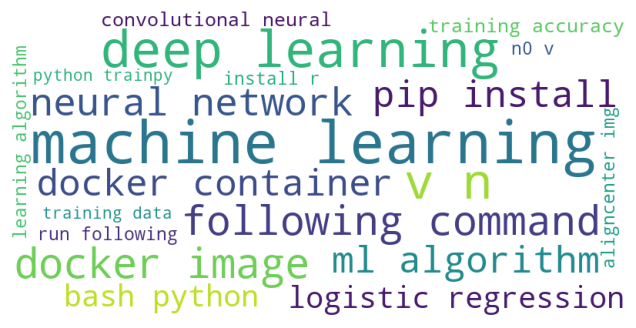

In [19]:
plot_bigrams(make_ngrams(python_words,2))
